(25, 2)


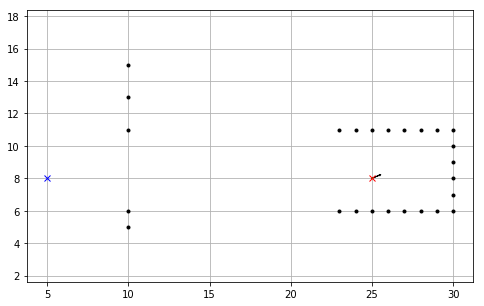

KeyboardInterrupt: 

In [62]:
%matplotlib inline
"""
Mobile robot motion planning sample with Dynamic Window Approach
author: Atsushi Sakai (@Atsushi_twi)
"""

import math
import numpy as np
import matplotlib.pyplot as plt

import sys


show_animation = True


class Config():
    # simulation parameters

    def __init__(self):
        # robot parameter
        self.max_speed = 1.0  # [m/s]
        self.min_speed = -0.5  # [m/s]
        self.max_yawrate = 40.0 * math.pi / 180.0  # [rad/s]
        self.max_accel = 0.2  # [m/ss]
        self.max_dyawrate = 40.0 * math.pi / 180.0  # [rad/ss]
        self.v_reso = 0.01  # [m/s]
        self.yawrate_reso = 0.1 * math.pi / 180.0  # [rad/s]
        self.dt = 0.1  # [s]
        self.predict_time = 3.0  # [s]
        self.to_goal_cost_gain = 1.0
        self.speed_cost_gain = 1.0
        self.robot_radius = 1.0  # [m]


def motion(x, u, dt):
    # motion model

    x[2] += u[1] * dt
    x[0] += u[0] * math.cos(x[2]) * dt
    x[1] += u[0] * math.sin(x[2]) * dt
    x[3] = u[0]
    x[4] = u[1]

    return x


def calc_dynamic_window(x, config):

    # Dynamic window from robot specification
    Vs = [config.min_speed, config.max_speed,
          -config.max_yawrate, config.max_yawrate]

    # Dynamic window from motion model
    Vd = [x[3] - config.max_accel * config.dt,
          x[3] + config.max_accel * config.dt,
          x[4] - config.max_dyawrate * config.dt,
          x[4] + config.max_dyawrate * config.dt]

    #  [vmin,vmax, yawrate min, yawrate max]
    dw = [max(Vs[0], Vd[0]), min(Vs[1], Vd[1]),
          max(Vs[2], Vd[2]), min(Vs[3], Vd[3])]

    return dw


def calc_trajectory(xinit, v, y, config):

    x = np.array(xinit)
    traj = np.array(x)
    time = 0
    while time <= config.predict_time:
        x = motion(x, [v, y], config.dt)
        traj = np.vstack((traj, x))
        time += config.dt

    return traj


def calc_final_input(x, u, dw, config, goal, ob):

    xinit = x[:]
    min_cost = 10000.0
    min_u = u
    min_u[0] = 0.0
    best_traj = np.array([x])

    # evalucate all trajectory with sampled input in dynamic window
    for v in np.arange(dw[0], dw[1], config.v_reso):
        for y in np.arange(dw[2], dw[3], config.yawrate_reso):
            traj = calc_trajectory(xinit, v, y, config)

            # calc cost
            to_goal_cost = calc_to_goal_cost(traj, goal, config)
            speed_cost = config.speed_cost_gain * \
                (config.max_speed - traj[-1, 3])
            ob_cost = calc_obstacle_cost(traj, ob, config)
            # print(ob_cost)

            final_cost = to_goal_cost + speed_cost + ob_cost

            #print (final_cost)

            # search minimum trajectory
            if min_cost >= final_cost:
                min_cost = final_cost
                min_u = [v, y]
                best_traj = traj

    return min_u, best_traj


def calc_obstacle_cost(traj, ob, config):
    # calc obstacle cost inf: collistion, 0:free

    skip_n = 2
    minr = float("inf")

    for ii in range(0, len(traj[:, 1]), skip_n):
        for i in range(len(ob[:, 0])):
            ox = ob[i, 0]
            oy = ob[i, 1]
            dx = traj[ii, 0] - ox
            dy = traj[ii, 1] - oy

            r = math.sqrt(dx**2 + dy**2)
            if r <= config.robot_radius:
                return float("Inf")  # collision

            if minr >= r:
                minr = r

    return 1.0 / minr  # OK


def calc_to_goal_cost(traj, goal, config):
    # calc to goal cost. It is 2D norm.

    goal_magnitude = math.sqrt(goal[0]**2 + goal[1]**2)
    traj_magnitude = math.sqrt(traj[-1, 0]**2 + traj[-1, 1]**2)
    dot_product = (goal[0] * traj[-1, 0]) + (goal[1] * traj[-1, 1])
    error = dot_product / (goal_magnitude * traj_magnitude)
    error_angle = math.acos(error)
    cost = config.to_goal_cost_gain * error_angle

    return cost


def dwa_control(x, u, config, goal, ob):
    # Dynamic Window control

    dw = calc_dynamic_window(x, config)

    u, traj = calc_final_input(x, u, dw, config, goal, ob)

    return u, traj


def plot_arrow(x, y, yaw, length=0.5, width=0.1):
    plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
              head_length=width, head_width=width)
    plt.plot(x, y)


def main():
    # initial state [x(m), y(m), yaw(rad), v(m/s), omega(rad/s)]
    x = np.array([25,8, math.pi / 8.0, 0.0, 0.0])
    # goal position [x(m), y(m)]
    goal = np.array([5,8])
    # obstacles [x(m) y(m), ....]
    
    ob = np.c_[[30,  8],
                 [30,  9],
                 [30, 10],
                 [30, 11],
                 [29, 11],
                 [28, 11],
                 [27, 11],
                 [26, 11],
                 [25, 11],
                 [24, 11],
                 [23, 11],
                 [10, 15],
                 [10, 13],
                 [10, 11],
                 [10,  6],
                 [10,  5],
                 [23,  6],
                 [24,  6],
                 [25,  6],
                 [26,  6],
                 [27,  6],
                 [28,  6],
                 [29,  6],
                 [30,  6],
                 [30,  7]].T

    print(ob.shape)
    u = np.array([0.0, 0.0])
    config = Config()
    traj = np.array(x)
    
    for i in range(1000):
        u, ltraj = dwa_control(x, u, config, goal, ob)

        x = motion(x, u, config.dt)
        traj = np.vstack((traj, x))  # store state history

        # print(traj)

        if i%100 == 0:
            plt.figure(figsize=(8,5))
            plt.plot(ltraj[:, 0], ltraj[:, 1], "-g")
            plt.plot(x[0], x[1], "rx")
            plt.plot(goal[0], goal[1], "bx")
            plt.plot(ob[:, 0], ob[:, 1], ".k")
            plot_arrow(x[0], x[1], x[2])
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.0001)

        # check goal
        if math.sqrt((x[0] - goal[0])**2 + (x[1] - goal[1])**2) <= config.robot_radius:
            print("Goal!!")
            break

    print("Done")
    if show_animation:
        plt.plot(traj[:, 0], traj[:, 1], "-r")
        plt.pause(0.0001)

    plt.show()


if __name__ == '__main__':
    main()

In [53]:
import heapq


class Cell(object):
    def __init__(self, x, y, reachable):
        """Initialize new cell.

        @param reachable is cell reachable? not a wall?
        @param x cell x coordinate
        @param y cell y coordinate
        @param g cost to move from the starting cell to this cell.
        @param h estimation of the cost to move from this cell
                 to the ending cell.
        @param f f = g + h
        """
        self.reachable = reachable
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0
        self.h = 0
        self.f = 0

    def __lt__(self, other):
        return self.f < other.f


class AStar(object):
    def __init__(self):
        # open list
        self.opened = []
        heapq.heapify(self.opened)
        # visited cells list
        self.closed = set()
        # grid cells
        self.cells = []
        self.grid_height = None
        self.grid_width = None

    def init_grid(self, width, height, walls, start, end):
        """Prepare grid cells, walls.
        @param width grid's width.
        @param height grid's height.
        @param walls list of wall x,y tuples.
        @param start grid starting point x,y tuple.
        @param end grid ending point x,y tuple.
        """
        self.grid_height = height
        self.grid_width = width
        for x in range(self.grid_width):
            for y in range(self.grid_height):
                if (x, y) in walls:
                    reachable = False
                else:
                    reachable = True
                self.cells.append(Cell(x, y, reachable))
        self.start = self.get_cell(*start)
        self.end = self.get_cell(*end)

    def get_heuristic(self, cell):
        """Compute the heuristic value H for a cell.
        Distance between this cell and the ending cell multiply by 10.
        @returns heuristic value H
        """
        return 10 * (abs(cell.x - self.end.x) + abs(cell.y - self.end.y))

    def get_cell(self, x, y):
        """Returns a cell from the cells list.
        @param x cell x coordinate
        @param y cell y coordinate
        @returns cell
        """
        return self.cells[x * self.grid_height + y]

    def get_adjacent_cells(self, cell):
        """Returns adjacent cells to a cell.
        Clockwise starting from the one on the right.
        @param cell get adjacent cells for this cell
        @returns adjacent cells list.
        """
        cells = []
        if cell.x < self.grid_width-1:
            cells.append(self.get_cell(cell.x+1, cell.y))
        if cell.y > 0:
            cells.append(self.get_cell(cell.x, cell.y-1))
        if cell.x > 0:
            cells.append(self.get_cell(cell.x-1, cell.y))
        if cell.y < self.grid_height-1:
            cells.append(self.get_cell(cell.x, cell.y+1))
        return cells

    def get_path(self):
        cell = self.end
        path = [(cell.x, cell.y)]
        while cell.parent is not self.start:
            cell = cell.parent
            path.append((cell.x, cell.y))

        path.append((self.start.x, self.start.y))
        path.reverse()
        return path

    def update_cell(self, adj, cell):
        """Update adjacent cell.
        @param adj adjacent cell to current cell
        @param cell current cell being processed
        """
        adj.g = cell.g + 10
        adj.h = self.get_heuristic(adj)
        adj.parent = cell
        adj.f = adj.h + adj.g

    def solve(self):
        """Solve maze, find path to ending cell.
        @returns path or None if not found.
        """
        # add starting cell to open heap queue
        heapq.heappush(self.opened, (self.start.f, self.start))
        while len(self.opened):
            # pop cell from heap queue
            f, cell = heapq.heappop(self.opened)
            # add cell to closed list so we don't process it twice
            self.closed.add(cell)
            # if ending cell, return found path
            if cell is self.end:
                return self.get_path()
            # get adjacent cells for cell
            adj_cells = self.get_adjacent_cells(cell)
            for adj_cell in adj_cells:
                if adj_cell.reachable and adj_cell not in self.closed:
                    if (adj_cell.f, adj_cell) in self.opened:
                        # if adj cell in open list, check if current path is
                        # better than the one previously found
                        # for this adj cell.
                        if adj_cell.g > cell.g + 10:
                            self.update_cell(adj_cell, cell)
                    else:
                        self.update_cell(adj_cell, cell)
                        # add adj cell to open list
                        heapq.heappush(self.opened, (adj_cell.f, adj_cell))

In [54]:
a = AStar()
walls = ((0, 5), 
         (1, 0), 
         (1, 1), 
         (1, 5), 
         (2, 3),
         (3, 1), 
         (3, 2), 
         (3, 5), 
         (4, 1), 
         (4, 4), 
         (5, 1)
        )



a.init_grid(6, 6, walls, (0, 0), (5, 5))
path = a.solve()
print([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4),
                        (2, 4), (3, 4), (3, 3), (4, 3), (5, 3), (5, 4),
                        (5, 5)])

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 4), (2, 4), (3, 4), (3, 3), (4, 3), (5, 3), (5, 4), (5, 5)]
